In [29]:
"""
Qick Custom IP based Trace Average test.
Signal -> Demodulation -> FIR x8 decimation -> Average Buffer (add signal itself)
In this program trace is averaged in Average Buffer on FPGA. Note that number of
average cannot exceed 2 ** 16, since each register for sample has size of 32 bits
(incomming sample has 16 bits each).
"""
import numpy as np
import math
import matplotlib.pyplot as plt
import time

from qick import *
from qick.pyro import make_proxy

class MultiPulseLoopBackExample(AveragerProgram):
    def initialize(self):
        # set the nyquist zone
        cfg = self.cfg
        freq_rf     = cfg["freq_rf"]
        # Declare RF generation channel
        self.declare_gen(
            ch      = 0,        # Channel
            nqz     = 2         # Nyquist Zone
        )
        self.declare_gen(
            ch      = 2,        # Channel
            nqz     = 2         # Nyquist Zone
        )
        # Declare RF input channel
        self.declare_readout(
            ch      = 0,        # Channel
            length  = (cfg["pulse_time"] + 100) * cfg["number_of_pulse"] + 200,       # Readout length
            number_of_trace_average = cfg["reps"]
        )
        # Convert RF frequency to ADC DDS register value
        self.add_gauss(
            0,                  # Set output channel number
            name    = "gauss",  # Set envelope name
            sigma   = int(cfg["pulse_time"] / 10),  # Sigma of gaussian
            length  = cfg["pulse_time"],       # Total length of envelope. 
                                                    # When envelope is used, lenght
                                                    # of waveform is specified in envelope,
                                                    # rather than pulse register
        )
        self.add_gauss(
            2,                  # Set output channel number
            name    = "gauss",  # Set envelope name
            sigma   = int(cfg["pulse_time"] / 10),  # Sigma of gaussian
            length  = cfg["pulse_time"],       # Total length of envelope. 
                                                    # When envelope is used, lenght
                                                    # of waveform is specified in envelope,
                                                    # rather than pulse register
        )
        self.synci(100)

    def body(self):
        cfg = self.cfg
        freq_rf     = cfg["freq_rf"]
        self.trigger(
            adcs    = [0],      # Readout channels
            adc_trig_offset = 100 # Readout will capture the data @ sync_t + 50
        )
        for i in range(cfg["number_of_pulse"]):
            # Set ADC DDS
            self.set_readout_registers(
                ch      = 0,        # Readout channel
                freq    = self.freq2reg_adc(
                    f       = freq_rf + 2e-5 * (i % 2),  # Frequency
                    ro_ch   = 0,        # Readout channel
                    gen_ch  = 0         # Generator channel for round up
                ),
                length  = 16, # Readout DDS multiplication length
                phrst   = 0,        # Readout DDS phase reset
            )
            self.readout(
                ch      = 0,        # Readout channel
                t       = (cfg["pulse_time"] + 100) * i + 100
            )
            self.setup_and_pulse(
                ch      = 0,        # Generator channel
                style   = "arb",    # Output is envelope * gain * DDS output
                freq    = self.freq2reg(
                    f       = freq_rf + 2e-5 * (i % 2),  # Frequency
                    gen_ch  = 0,        # Generator channel
                    ro_ch   = 0         # Readout channel for round up
                ),
                phase   = self.deg2reg(0, gen_ch = 0),        # Generator DDS phase
                gain    = int(1000), # Generator amplitude
                phrst   = 0,        # Generator DDS phase reset
                outsel  = "product",# Output is envelope * gain * DDS output
                waveform= "gauss",  # Set envelope to be multiplied
                t       = (cfg["pulse_time"] + 100) * i + 100
            )
        self.sync_all(1000)



Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_aea4f608d3224f858128d108fbc24b30@192.168.2.99:39643
Acquisition time for 250000 averages: 5.639181137084961 s


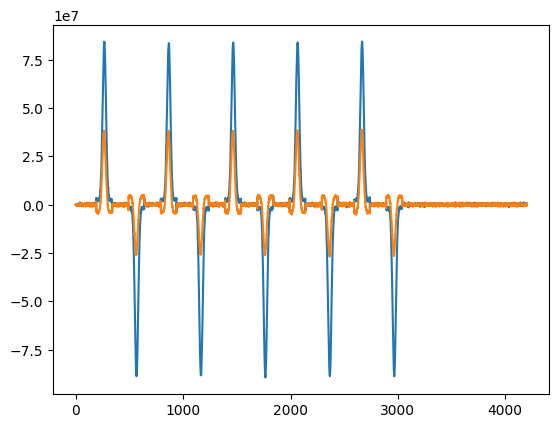

In [30]:
# Qick version : 0.2.357
(soc, soccfg) = make_proxy("192.168.2.99")

# Set DAC Channel 0 attenuation 31 dB and 31 dB, and turn on DAC channel
soc.rfb_set_gen_rf(0,10,10)
soc.rfb_set_gen_rf(2,31,31)
# Set DAC Channel filter as bypass mode
soc.rfb_set_gen_filter(0,fc = 2.5, ftype = "lowpass")
soc.rfb_set_gen_filter(2,fc = 2.5, ftype = "lowpass")

# Set ADC Channel attenuation 31 dB, and turn on ADC channel
soc.rfb_set_ro_rf(0,10)
# Set ADC Channel filter as bypass mode
soc.rfb_set_ro_filter(0, fc = 2.5, ftype = "lowpass")

start_time = time.time()
cfg = {
    # Experiment Setup
    "reps" : 50000,
    "expts" : 1,
    # Parameter Setup
    "freq_rf" : 501.10000,
    "pulse_time" : 300,
    "number_of_pulse" : 10
}
prog = MultiPulseLoopBackExample(
    soccfg,
    cfg
)
LEN = 5
data = (prog.acquire_trace_avg(soc = soc, progress = True))[0][0]
for i in range(LEN):
    data += (prog.acquire_trace_avg(soc = soc, progress = True))[0][0]
end_time = time.time()

print(f"Acquisition time for {cfg['reps']*LEN} averages: {end_time - start_time} s")
plt.figure()
plt.plot(data)
plt.show()

In [51]:
"""
Qick Custom IP based Trace Average test.
Signal -> Demodulation -> FIR x8 decimation -> Average Buffer (add signal itself)
In this program trace is averaged in Average Buffer on FPGA. Note that number of
average cannot exceed 2 ** 16, since each register for sample has size of 32 bits
(incomming sample has 16 bits each).
"""
import numpy as np
import math
import matplotlib.pyplot as plt
import time

from qick import *
from qick.pyro import make_proxy

class MultiPulseLoopBackExample(AveragerProgram):
    def initialize(self):
        # set the nyquist zone
        cfg = self.cfg
        freq_rf     = cfg["freq_rf"]
        # Declare RF generation channel
        self.declare_gen(
            ch      = 0,        # Channel
            nqz     = 2         # Nyquist Zone
        )
        self.declare_gen(
            ch      = 2,        # Channel
            nqz     = 2         # Nyquist Zone
        )
        # Declare RF input channel
        self.declare_readout(
            ch      = 0,        # Channel
            length  = (cfg["pulse_time"] + 100) * cfg["number_of_pulse"] + 200,       # Readout length
            number_of_trace_average = cfg["reps"]
        )
        # Convert RF frequency to ADC DDS register value
        self.add_gauss(
            0,                  # Set output channel number
            name    = "gauss",  # Set envelope name
            sigma   = int(cfg["pulse_time"] / 10),  # Sigma of gaussian
            length  = cfg["pulse_time"],       # Total length of envelope. 
                                                    # When envelope is used, lenght
                                                    # of waveform is specified in envelope,
                                                    # rather than pulse register
        )
        self.add_gauss(
            2,                  # Set output channel number
            name    = "gauss",  # Set envelope name
            sigma   = int(cfg["pulse_time"] / 10),  # Sigma of gaussian
            length  = cfg["pulse_time"],       # Total length of envelope. 
                                                    # When envelope is used, lenght
                                                    # of waveform is specified in envelope,
                                                    # rather than pulse register
        )
        self.synci(100)

    def body(self):
        cfg = self.cfg
        freq_rf     = cfg["freq_rf"]
        self.trigger(
            adcs    = [0],      # Readout channels
            adc_trig_offset = 100 # Readout will capture the data @ sync_t + 50
        )
        for i in range(cfg["number_of_pulse"]):
            # Set ADC DDS
            self.set_readout_registers(
                ch      = 0,        # Readout channel
                freq    = self.freq2reg_adc(
                    f       = freq_rf + 1e-5 * (i % 2),  # Frequency
                    ro_ch   = 0,        # Readout channel
                    gen_ch  = 0         # Generator channel for round up
                ),
                length  = 16, # Readout DDS multiplication length
                phrst   = 0,        # Readout DDS phase reset
            )
            self.readout(
                ch      = 0,        # Readout channel
                t       = (cfg["pulse_time"] + 100) * i + 100
            )
            self.setup_and_pulse(
                ch      = 0,        # Generator channel
                style   = "arb",    # Output is envelope * gain * DDS output
                freq    = self.freq2reg(
                    f       = freq_rf + 1e-5 * (i % 2),  # Frequency
                    gen_ch  = 0,        # Generator channel
                    ro_ch   = 0         # Readout channel for round up
                ),
                phase   = self.deg2reg(0, gen_ch = 0),        # Generator DDS phase
                gain    = int(1000), # Generator amplitude
                phrst   = 0,        # Generator DDS phase reset
                outsel  = "product",# Output is envelope * gain * DDS output
                waveform= "gauss",  # Set envelope to be multiplied
                t       = (cfg["pulse_time"] + 100) * i + 100
            )
        self.wait_all()
        self.sync_all(1000)



Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_aea4f608d3224f858128d108fbc24b30@192.168.2.99:39643
Acquisition time for 250000 averages: 5.559038400650024 s


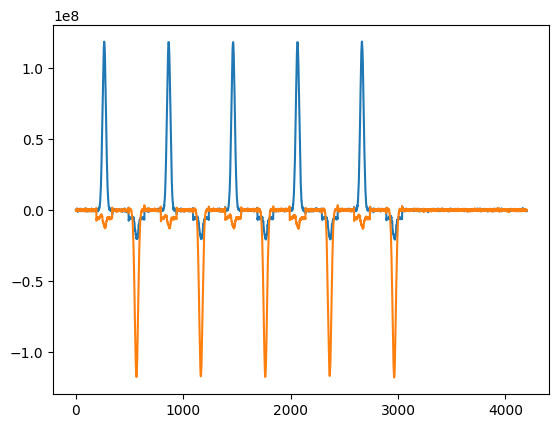

In [57]:
# Qick version : 0.2.357
(soc, soccfg) = make_proxy("192.168.2.99")

# Set DAC Channel 0 attenuation 31 dB and 31 dB, and turn on DAC channel
soc.rfb_set_gen_rf(0,10,10)
soc.rfb_set_gen_rf(2,31,31)
# Set DAC Channel filter as bypass mode
soc.rfb_set_gen_filter(0,fc = 2.5, ftype = "lowpass")
soc.rfb_set_gen_filter(2,fc = 2.5, ftype = "lowpass")

# Set ADC Channel attenuation 31 dB, and turn on ADC channel
soc.rfb_set_ro_rf(0,10)
# Set ADC Channel filter as bypass mode
soc.rfb_set_ro_filter(0, fc = 2.5, ftype = "lowpass")

start_time = time.time()
cfg = {
    # Experiment Setup
    "reps" : 50000,
    "expts" : 1,
    # Parameter Setup
    "freq_rf" : 540.10000,
    "pulse_time" : 300,
    "number_of_pulse" : 10
}
prog = MultiPulseLoopBackExample(
    soccfg,
    cfg
)
LEN = 5
data = (prog.acquire_trace_avg(soc = soc, progress = True))[0][0]
for i in range(LEN):
    data += (prog.acquire_trace_avg(soc = soc, progress = True))[0][0]
end_time = time.time()

print(f"Acquisition time for {cfg['reps']*LEN} averages: {end_time - start_time} s")
plt.figure()
plt.plot(data)
plt.show()

In [83]:
"""
Qick Custom IP based Trace Average test.
Signal -> Demodulation -> FIR x8 decimation -> Average Buffer (add signal itself)
In this program trace is averaged in Average Buffer on FPGA. Note that number of
average cannot exceed 2 ** 16, since each register for sample has size of 32 bits
(incomming sample has 16 bits each).
"""
import numpy as np
import math
import matplotlib.pyplot as plt
import time

from qick import *
from qick.pyro import make_proxy

class MultiPulseLoopBackExample(AveragerProgram):
    def initialize(self):
        # set the nyquist zone
        cfg = self.cfg
        freq_rf     = cfg["freq_rf"]
        # Declare RF generation channel
        self.declare_gen(
            ch      = 0,        # Channel
            nqz     = 2         # Nyquist Zone
        )
        self.declare_gen(
            ch      = 2,        # Channel
            nqz     = 2         # Nyquist Zone
        )
        # Declare RF input channel
        self.declare_readout(
            ch      = 0,        # Channel
            length  = (cfg["pulse_time"] + 100) * cfg["number_of_pulse"] + 200,       # Readout length
            number_of_trace_average = cfg["reps"]
        )
        # Convert RF frequency to ADC DDS register value
        self.add_gauss(
            0,                  # Set output channel number
            name    = "gauss",  # Set envelope name
            sigma   = int(cfg["pulse_time"] / 10),  # Sigma of gaussian
            length  = cfg["pulse_time"],       # Total length of envelope. 
                                                    # When envelope is used, lenght
                                                    # of waveform is specified in envelope,
                                                    # rather than pulse register
        )
        self.add_gauss(
            2,                  # Set output channel number
            name    = "gauss",  # Set envelope name
            sigma   = int(cfg["pulse_time"] / 10),  # Sigma of gaussian
            length  = cfg["pulse_time"],       # Total length of envelope. 
                                                    # When envelope is used, lenght
                                                    # of waveform is specified in envelope,
                                                    # rather than pulse register
        )
        self.synci(100)

    def body(self):
        cfg = self.cfg
        freq_rf     = cfg["freq_rf"]
        self.trigger(
            adcs    = [0],      # Readout channels
            adc_trig_offset = 100 # Readout will capture the data @ sync_t + 50
        )
        for i in range(cfg["number_of_pulse"]):
            # Set ADC DDS
            self.set_readout_registers(
                ch      = 0,        # Readout channel
                freq    = self.freq2reg_adc(
                    f       = freq_rf + 1e-5 * (i),  # Frequency
                    ro_ch   = 0,        # Readout channel
                    gen_ch  = 0         # Generator channel for round up
                ),
                length  = 16, # Readout DDS multiplication length
                phrst   = 0,        # Readout DDS phase reset
            )
            self.readout(
                ch      = 0,        # Readout channel
                t       = (cfg["pulse_time"] + 100) * i + 100
            )
            self.setup_and_pulse(
                ch      = 0,        # Generator channel
                style   = "arb",    # Output is envelope * gain * DDS output
                freq    = self.freq2reg(
                    f       = freq_rf + 1e-5 * (i),  # Frequency
                    gen_ch  = 0,        # Generator channel
                    ro_ch   = 0         # Readout channel for round up
                ),
                phase   = self.deg2reg(0, gen_ch = 0),        # Generator DDS phase
                gain    = int(1000), # Generator amplitude
                phrst   = 0,        # Generator DDS phase reset
                outsel  = "product",# Output is envelope * gain * DDS output
                waveform= "gauss",  # Set envelope to be multiplied
                t       = (cfg["pulse_time"] + 100) * i + 100
            )
        self.wait_all()
        self.sync_all(1000)



Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_aea4f608d3224f858128d108fbc24b30@192.168.2.99:39643
Acquisition time for 250000 averages: 5.553759813308716 s


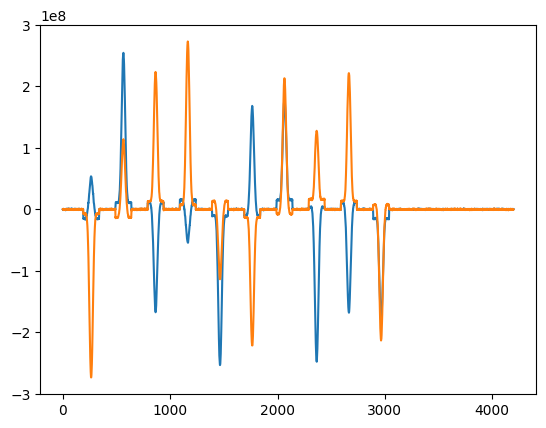

In [85]:
# Qick version : 0.2.357
(soc, soccfg) = make_proxy("192.168.2.99")

# Set DAC Channel 0 attenuation 31 dB and 31 dB, and turn on DAC channel
soc.rfb_set_gen_rf(0,30,10)
soc.rfb_set_gen_rf(2,31,31)
# Set DAC Channel filter as bypass mode
soc.rfb_set_gen_filter(0,fc = 2.5, ftype = "lowpass")
soc.rfb_set_gen_filter(2,fc = 2.5, ftype = "lowpass")

# Set ADC Channel attenuation 31 dB, and turn on ADC channel
soc.rfb_set_ro_rf(0,10)
# Set ADC Channel filter as bypass mode
soc.rfb_set_ro_filter(0, fc = 2.5, ftype = "lowpass")

start_time = time.time()
cfg = {
    # Experiment Setup
    "reps" : 50000,
    "expts" : 1,
    # Parameter Setup
    "freq_rf" : 1501.10000,
    "pulse_time" : 300,
    "number_of_pulse" : 10
}
prog = MultiPulseLoopBackExample(
    soccfg,
    cfg
)
LEN = 5
data = (prog.acquire_trace_avg(soc = soc, progress = True))[0][0]
for i in range(LEN):
    data += (prog.acquire_trace_avg(soc = soc, progress = True))[0][0]
end_time = time.time()

print(f"Acquisition time for {cfg['reps']*LEN} averages: {end_time - start_time} s")
plt.figure()
plt.plot(data)
plt.show()

In [79]:
"""
Qick Custom IP based Trace Average test.
Signal -> Demodulation -> FIR x8 decimation -> Average Buffer (add signal itself)
In this program trace is averaged in Average Buffer on FPGA. Note that number of
average cannot exceed 2 ** 16, since each register for sample has size of 32 bits
(incomming sample has 16 bits each).
"""
import numpy as np
import math
import matplotlib.pyplot as plt
import time

from qick import *
from qick.pyro import make_proxy

class MultiPulseLoopBackExample(AveragerProgram):
    def initialize(self):
        # set the nyquist zone
        cfg = self.cfg
        freq_rf     = cfg["freq_rf"]
        # Declare RF generation channel
        self.declare_gen(
            ch      = 0,        # Channel
            nqz     = 2         # Nyquist Zone
        )
        self.declare_gen(
            ch      = 2,        # Channel
            nqz     = 2         # Nyquist Zone
        )
        # Declare RF input channel
        self.declare_readout(
            ch      = 0,        # Channel
            length  = cfg["pulse_time"] + 150,       # Readout length
            number_of_trace_average = cfg["reps"]
        )
        self.synci(100)

    def body(self):
        cfg = self.cfg
        freq_rf     = cfg["freq_rf"]
        self.trigger(
            adcs    = [0],      # Readout channels
            adc_trig_offset = 100 # Readout will capture the data @ sync_t + 50
        )
        # Set ADC DDS
        self.set_readout_registers(
            ch      = 0,        # Readout channel
            freq    = self.freq2reg_adc(
                f       = 0,  # Frequency
                ro_ch   = 0,        # Readout channel
                gen_ch  = 0         # Generator channel for round up
            ),
            length  = 16, # Readout DDS multiplication length
            phrst   = 0,        # Readout DDS phase reset
        )
        self.readout(
            ch      = 0,        # Readout channel
            t       = 100
        )
        self.setup_and_pulse(
            ch      = 0,        # Generator channel
            style   = "const",    # Output is envelope * gain * DDS output
            freq    = self.freq2reg(
                f       = freq_rf,  # Frequency
                gen_ch  = 0,        # Generator channel
                ro_ch   = 0         # Readout channel for round up
            ),
            phase   = self.deg2reg(0, gen_ch = 0),        # Generator DDS phase
            gain    = int(35000), # Generator amplitude
            phrst   = 1,        # Generator DDS phase reset
            length  = cfg["pulse_time"],
            t       = 100
        )
        self.wait_all()
        self.sync_all(1000)



Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_aea4f608d3224f858128d108fbc24b30@192.168.2.99:39643
Acquisition time for 2500000 averages: 11.393593072891235 s


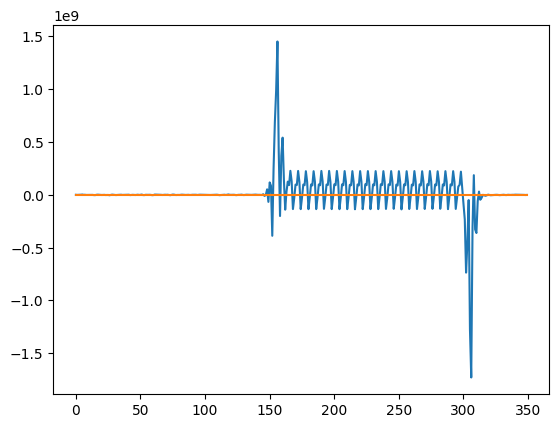

In [ ]:
# Qick version : 0.2.357
(soc, soccfg) = make_proxy("192.168.2.99")

# Set DAC Channel 0 attenuation 31 dB and 31 dB, and turn on DAC channel
soc.rfb_set_gen_rf(0,10,10)
soc.rfb_set_gen_rf(2,31,31)
# Set DAC Channel filter as bypass mode
soc.rfb_set_gen_filter(0,fc = 2.5, ftype = "lowpass")
soc.rfb_set_gen_filter(2,fc = 2.5, ftype = "lowpass")

# Set ADC Channel attenuation 31 dB, and turn on ADC channel
soc.rfb_set_ro_rf(0,10)
# Set ADC Channel filter as bypass mode
soc.rfb_set_ro_filter(0, fc = 2.5, ftype = "lowpass")

start_time = time.time()
cfg = {
    # Experiment Setup
    "reps" : 50000,
    "expts" : 1,
    # Parameter Setup
    "freq_rf" : 150.00000,
    "pulse_time" : 200,
}
prog = MultiPulseLoopBackExample(
    soccfg,
    cfg
)
LEN = 50
data = (prog.acquire_trace_avg(soc = soc, progress = True))[0][0]
for i in range(LEN):
    data += (prog.acquire_trace_avg(soc = soc, progress = True))[0][0]
end_time = time.time()

print(f"Acquisition time for {cfg['reps']*LEN} averages: {end_time - start_time} s")
plt.figure()
plt.plot(data)
plt.show()